In [13]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model


# SPLITTING DATASET

In [23]:
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
#     color_mode='grayscale',  # grayscale makes the images  blue and yellow
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 37663 files belonging to 2 classes.


In [4]:
ds_valid_ = image_dataset_from_directory(
    'val',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
#     color_mode='grayscale',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
ds_test_ = image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
#     color_mode='grayscale',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)



Found 16 files belonging to 2 classes.
Found 484 files belonging to 2 classes.


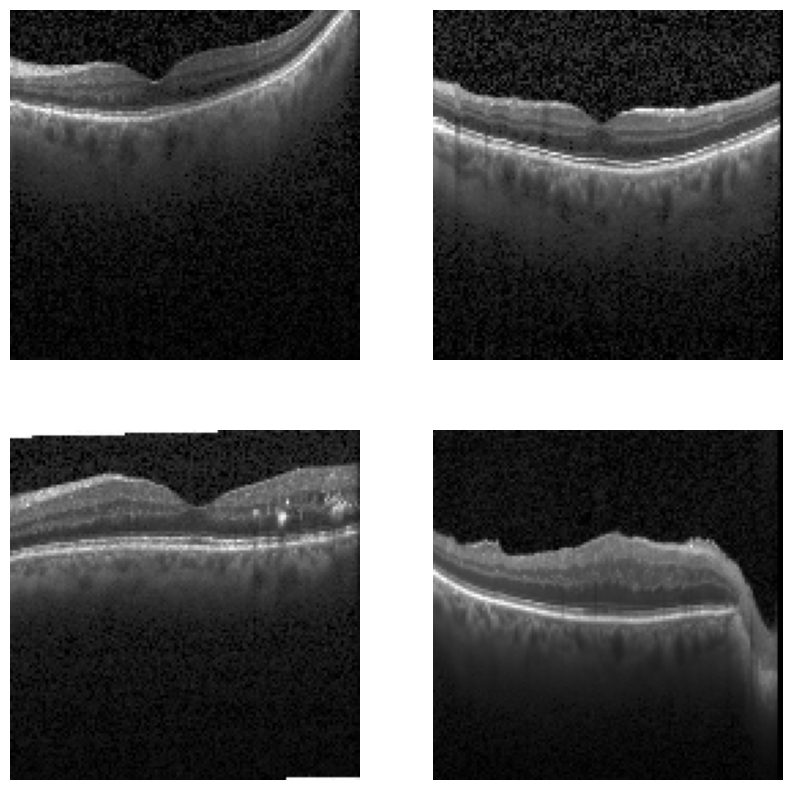

In [24]:
import matplotlib.pyplot as plt
class_names = ds_train_.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


# Making a model

In [6]:
from keras.applications.mobilenet import MobileNet
from tensorflow import keras
from tensorflow.keras import layers
IMG_SIZE=128
base_model=MobileNet(include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3)) # understand this 
base_model.trainable=False #cuz most of the params in our pretrained model are already trained
# base_model.summary()

In [8]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
])
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [9]:
model = keras.Sequential([
#     resize_and_rescale,
#     data_augmentation, #binary acc was 50% so discarded
    
    base_model, 
    layers.Flatten(),
#     layers.Conv2D(16, (3,3), activation='relu'),#, input_shape=(128, 128, 3)),
#     layers.MaxPooling2D(2, 2),
#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),    
    layers.Dropout(0.2),
#     layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
#     base_model,    
#     layers.Flatten(),
#     layers.Dense(units=6, activation="relu"),
#     layers.Dense(units=1, activation="sigmoid"),
])

optimizer = keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dropout (Dropout)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 11,618,497
Trainable params: 8,389,633
Non-trainable params: 3,228,864
___________________________________

In [ ]:
epochs=10
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,    
    verbose=1,
)

In [ ]:
# print(history.history.keys())
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
realLabesls = list(map(lambda x: x[1], ds_test))

model.evaluate(ds_test)
predictions = model.predict(ds_test)
# predLabel = list(map(lambda x: tf.nn.softmax(x),y_train)
for i in range(len(predictions)):
    predictions[i] = np.max(tf.nn.softmax(predictions[i]))
predictions
# predictions
score = np.max(tf.nn.softmax(predictions[222]))
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test_loss, test_acc = model.evaluate(ds_test,ds_train, verbose=2)

8/8 [==============================] - 4s 440ms/step - loss: 0.0489 - binary_accuracy: 0.9855
1.0
This image most likely belongs to DME with a 100.00 percent confidence.


In [15]:
testimage=image.load_img('test/DME/DME-1081406-1.jpeg', target_size=(128, 128))
testimage = image.img_to_array(testimage)
testimage=np.expand_dims(testimage, axis=0)


predictions = model.predict(testimage)

# predictions = np.max(tf.nn.softmax(predictions))
predictions
# predictions
score = np.max(tf.nn.softmax(predictions))
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1.0
This image most likely belongs to DME with a 100.00 percent confidence.


In [18]:
ds_valid_ = image_dataset_from_directory(
    'predict',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
#     color_mode='grayscale',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
    )
    # Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    )
class_names = ['DME','NORMAL']
y_pred_prob = model.predict(ds_valid)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
for i in range(len(y_pred)):
    y_pred[i] = np.max(tf.nn.softmax(predictions[i]))
y_pred
# predictions
score = np.max(tf.nn.softmax(y_pred[222]))
print(
"This image most likely belongs to {} with a {:.2f} percent confidence."
.format(class_names[np.argmax(score)], 100 * np.max(score))
)
    

Found 0 files belonging to 0 classes.


ValueError: When passing `label_mode="binary"`, there must be exactly 2 class_names. Received: class_names=[]

In [33]:
from keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
test_image = image.load_img('predict/NORMAL-9251-13.jpeg', target_size=(128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = tf.image.convert_image_dtype(test_image, dtype=tf.float32)

# Make predictions on the single image
predictions = model.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class name based on the index (assuming you have a list of class names)
predicted_class_name = class_names[predicted_class_index]

# Get the confidence score for the predicted class
confidence = np.max(tf.nn.softmax(predictions))

# Print the results
print(f"This image most likely belongs to {predicted_class_name} with a {100 * confidence:.2f}% confidence.")


This image most likely belongs to DME with a 100.00% confidence.


In [27]:
print(predictions)

[[0.00332737]]


In [28]:
predicted_class_index

0

In [29]:
class_names

['DME', 'NORMAL']

In [19]:
from keras.preprocessing import image
import numpy as np

# Load an image and resize it
test_image = image.load_img('test/NORMAL/NORMAL-101880-1.jpeg', target_size=(128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Make predictions
predictions = model.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class name based on the index (assuming you have a list of class names)
predicted_class_name = class_names[predicted_class_index]

# Get the confidence score for the predicted class
confidence = predictions[0, predicted_class_index]

# Print the results
print(f"This image most likely belongs to {predicted_class_name} with a {100 * confidence:.2f}% confidence.")


This image most likely belongs to DME with a 28.28% confidence.


In [18]:
from sklearn.metrics import roc_curve, auc

# fpr, tpr, _ = roc_curve(ds_test.classes, predictions)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# loss, acc = model.evaluate(ds_test, steps=3, verbose=0)
# loss, acc

In [ ]:
model.save('DMEmodel.h5')

In [5]:
model =load_model('DMEmodel.h5')

In [10]:
from sklearn.metrics import confusion_matrix,classification_report

In [12]:
classreport = classification_report(y_true, y_pred, zero_division=1) 

In [23]:
predLabel = list(map(lambda x: tf.nn.softmax(x),predictions))

In [46]:
print(len(ds_test))

8


In [47]:
print(len(realLabesls))

8


In [36]:
newpredlabel = predLabel[:8:]

In [41]:
print(len(newpredlabel))

8


In [42]:
newpredlabel

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

In [11]:
y_true = []
for x, y in ds_valid:
    y_true.extend(tf.argmax(y, axis=1).numpy())

# Get predicted labels
y_pred_prob = model.predict(ds_valid)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Generate classification report
report = classification_report(y_true, y_pred)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [ ]:
realLabesls = list(map(lambda x: x[1], ds_test))